

# Data Challenge 1: Employee Retention
   
## Goal:
Employee turnover is a very costly problem for companies. The cost of replacing an employee is often larger than 100K USD, taking into account the time spent to interview and find a replacement, placement fees, sign-on bonuses and the loss of productivity for several months.

t is only natural then that data science has started being applied to this area. Understanding why and when employees are most likely to leave can lead to actions to improve employee retention as well as planning new hiring in advance. This application of DS is sometimes called people analytics or people data science (if you see a job title: people data scientist, this is your job).

In this challenge, you have a data set with info about the employees and have to predict when employees are going to quit by understanding the main drivers of employee churn.

## Challenge Description
We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as avg salary during her tenure, dept, and yrs of experience.

As said above, the goal is to predict employee retention and understand its main drivers

## Hints:
- What are the main factors that drive employee churn? Do they make sense? Explain your findings.
- What might you be able to do for the company to address employee Churn, what would be follow-up actions?
- If you could add to this data set just one variable that could help explain employee churn, what would that be?

Your output should be in the form a a jupyter notebook and pdf output of a jupyter notebook in which you specify your results and how you got them.




# Preprocessing and feature engineering

First we import a few libraries that we use later

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


We then load the data and inspect its columns and entries

In [2]:
df=pd.read_csv("employee_retention_data.csv")

In [3]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [4]:
# Number of people who have quit
df["quit_date"].isnull().sum()

11192

Here we create a new column indicating whether the employee has quit or not.
We also create a new column for employment duration of the employee in days.

In [5]:
# creating a column indicating whether the employee has quit (1) or not (0)

df["quit"]=~df["quit_date"].isnull()
df["quit"]=df["quit"].astype(int)

In [6]:
# a function to calculate the duration of employment in days
def emp_dur(join_date, quit_date, quit):
    if quit==0:
        quit_date="2015-12-13"
    years=list(map(int, quit_date.split("-")))[0]-list(map(int, join_date.split("-")))[0]
    months=list(map(int, quit_date.split("-")))[1]-list(map(int, join_date.split("-")))[1]
    days=list(map(int, quit_date.split("-")))[2]-list(map(int, join_date.split("-")))[2]
    
    return years*365+months*30+days

In [7]:
#  creating the new column for employment duration in days

df["employment_duration"]=df.apply(lambda x: emp_dur(x['join_date'], x['quit_date'], x['quit']), axis=1)
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit,employment_duration
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,581
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,340
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,0,425
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,388
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,1040


Here, we remove two outliers in seniority who had 99 years of experience! 

In [8]:
# There are two outliers in seniority with 99 years of experience (probably wrong data). We drop them!
# df[df["seniority"]>29].index
df.drop(axis=0, index=df[df["seniority"]>29].index, inplace=True)

Here, we do a paitplot for numerical features of our dataset and distinguish them by whether the employee has quit or not

C:\Users\hhash\Anaconda3\envs\Insight\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


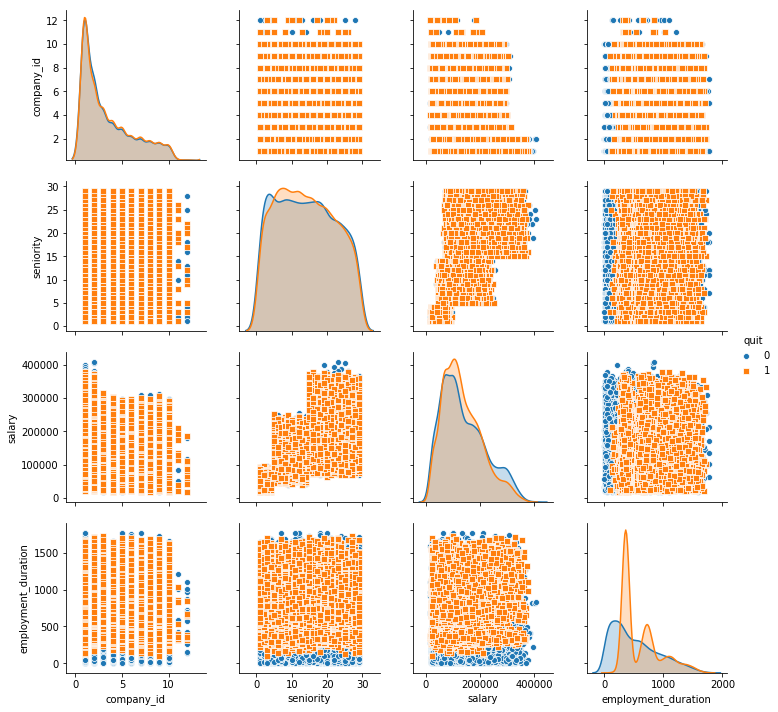

In [9]:
# pairplot of numerical features i.e. ['company_id','seniority','salary','employment_duration'] with hue of whether they quit or not
sns.pairplot(df,vars=['company_id','seniority','salary','employment_duration'], hue="quit",markers=["o", "s"])


We also check the number of employees who are still with the companies or who have quit, over all departments.

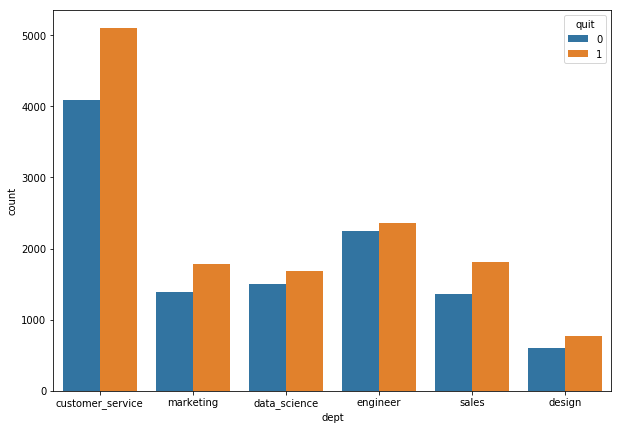

In [10]:
# comparison of churn rate in different departments

plt.figure(figsize=(10,7))
sns.countplot(data=df, x="dept", hue="quit")

We also create a new feature as the joining month for each employee to capture any seasonality

In [11]:
# capturing seasonality if any, by creating a new column for joining month for each employee

df["join_month"]=df["join_date"].map(lambda x: x.split("-")[1])
# df["quit_month"]=df["quit_date"].map(lambda x: list(map(int, x.split("-")))[1])

Here we create dummy variables for categorical features. This is needed for our classification models later on.

In [12]:
#  creating the dummy variables for categorical features: company ID, department, and joining month

df["company_id_cat"]=df["company_id"].astype(str)
df_cat = pd.get_dummies(df[["company_id_cat","dept","join_month"]],drop_first = True)

In [13]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit,employment_duration,join_month,company_id_cat
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,581,03,7
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,340,04,7
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,0,425,10,4
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,388,05,7
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,1040,10,2


In [14]:
df_cat.columns

Index(['company_id_cat_10', 'company_id_cat_11', 'company_id_cat_12',
       'company_id_cat_2', 'company_id_cat_3', 'company_id_cat_4',
       'company_id_cat_5', 'company_id_cat_6', 'company_id_cat_7',
       'company_id_cat_8', 'company_id_cat_9', 'dept_data_science',
       'dept_design', 'dept_engineer', 'dept_marketing', 'dept_sales',
       'join_month_02', 'join_month_03', 'join_month_04', 'join_month_05',
       'join_month_06', 'join_month_07', 'join_month_08', 'join_month_09',
       'join_month_10', 'join_month_11', 'join_month_12'],
      dtype='object')

In [15]:
# df_cat.columns
X=pd.concat([df[['seniority','salary','employment_duration']], df_cat], axis=1)
y=df['quit']

## Modeling and validation: Classification

- Below we train two different models namely, logistic regression and random forest for classification
- for both models, we split the data into train and split with ratio of 30:70

### Performance

- The trained logistic regression and random forest models below, have F-scores of 0.73 and 0.84 for predicting who quits
- Based on logistic regression, the top three informative features are: employment duration, seniority, department type
- Based on random forest, the top three informative features are: employment duration, salary, seniority

###  Conclusion

In general the available features are very limited and not very informative. Features on incentives such as bonuses and vacation
days could be helpful. But given that salary and employment duration are already two driving factors, I would choose salary growth rate if I wanted to add another feature. 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
lr=LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.31      0.44      3343
           1       0.61      0.90      0.73      4067

   micro avg       0.63      0.63      0.63      7410
   macro avg       0.67      0.61      0.58      7410
weighted avg       0.66      0.63      0.60      7410

[[1046 2297]
 [ 408 3659]]


C:\Users\hhash\Anaconda3\envs\Insight\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [17]:
lr_feature_importance =pd.DataFrame(lr.coef_[0], index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
lr_feature_importance.head(5)

,importance
employment_duration,0.000643
seniority,0.000557
dept_sales,0.000027
join_month_04,0.000026
join_month_05,0.000024


In [18]:
rf=RandomForestClassifier(max_depth = 30, random_state = 42)
rf.fit(X_train, y_train)
y_pred_rf=rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

C:\Users\hhash\Anaconda3\envs\Insight\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.79      0.82      0.81      3343
           1       0.85      0.83      0.84      4067

   micro avg       0.82      0.82      0.82      7410
   macro avg       0.82      0.82      0.82      7410
weighted avg       0.82      0.82      0.82      7410

[[2727  616]
 [ 705 3362]]


In [19]:
rf_feature_importance = pd.DataFrame(rf.feature_importances_, index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

In [20]:
rf_feature_importance.head(5)

,importance
employment_duration,0.551812
salary,0.149806
seniority,0.106883
join_month_03,0.011425
join_month_10,0.010779
